# <center> Innoscape - Telecom Paristech - Projet fil rouge </center>
# <center> Mapping Groupes de produits </center>

In [5]:
# Librairies 
import pandas as pd
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns

import re
import random
from preprocessing import *
from gensim import models, corpora

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, cross_val_score

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

chemin = "../../Data/"

In [9]:
import xgboost as xgb
#import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

## Importation des données

In [10]:
# Importation des données vendeurs
df_seller = pd.read_csv(chemin + 'df_total_clean.csv', sep = ",").fillna('')
df_seller.drop("Unnamed: 0",axis=1,inplace=True)

In [11]:
#chargement du dataset
df_train_all = pd.read_csv('20190403_df_train_all.csv', index_col=0)
df_train_all.head()

productfamily_seller   prodcategory4_seller  \
0     Colles à carrelage     Colles à carrelage   
3                 Mastic                 Mastic   
4                  Cires                  Cires   
6      Perceuse visseuse              Perceuses   
7  Produits d étanchéité  Produits d étanchéité   

              prodcategory3_seller                     prodcategory2_seller  \
0               Colles et adhésifs                            Quincaillerie   
3               Colles et adhésifs                            Quincaillerie   
4  Peintures teintures et solvants  Peintures outils et traitement des murs   
6        Outillage électroportatif      Outillage à main et électroportatif   
7               Colles et adhésifs                            Quincaillerie   

  prodcategory1_seller                                 productseller_name  \
0            Bricolage  SikaCeram Xtra   Colle à carrelage intérieur e...   
3            Bricolage              Colle mastic pour joints d étanchéité   
4            Bricolage  Sikagard Protection Sol MAT   Imperméabilisant...   
6            Bricolage  Perceuse visseuse RYOBI 18V OnePlus   1 batter...   
7            Bricolage  Sika Multiseal   Bande d étanchéité autocollan...   

  productfamily_seller_clean prodcategory4_seller_clean  \
0            colle carrelage            colle carrelage   
3                     mastic                     mastic   
4                       cire                       cire   
6   perceur visseur|visseuse                    perceur   
7         etancheite produit         etancheite produit   

  prodcategory3_seller_clean      prodcategory2_seller_clean  \
0              colle adhesif                   quincaillerie   
3              colle adhesif                   quincaillerie   
4  teinture peinture solvant   peinture outil traitement mur   
6  outillage electroportatif  outillage electroportatif main   
7              colle adhesif                   quincaillerie   

  prodcategory1_seller_clean  \
0                  bricolage   
3                  bricolage   
4                  bricolage   
6                  bricolage   
7                  bricolage   

                            productseller_name_clean  \
0  max blanc exterieur carreau xtra interieur col...   
3                      etancheite mastic colle joint   
4           mat sol impermeabiliser effet protection   
6  oneplus visseur|visseuse lithium perceur batte...   
7  etancheite dechirure cuit terre bander autocol...   

                     Product_family_innoscape  
0                   mastic, colle, étanchéité  
3                   mastic, colle, étanchéité  
4                   mastic, colle, étanchéité  
6  perceuse, perforateur et visseuse sans fil  
7                   mastic, colle, étanchéité

## TF-IDF:

On commence par regrouper toutes les données textuelles dans une seule colonne de texte:

In [12]:
df_train_all['concat'] = df_train_all['productfamily_seller_clean'] + ' ' + \
                     df_train_all['prodcategory4_seller_clean'] + ' ' + \
                     df_train_all['prodcategory3_seller_clean'] + ' ' + \
                     df_train_all['prodcategory2_seller_clean'] + ' ' + \
                     df_train_all['prodcategory1_seller_clean'] + ' ' + \
                     df_train_all['productseller_name_clean']

On retire ensuite les familles dont les effectifs sont trop faibles pour entraîner un classifieur:

In [13]:
fam_counts = df_train_all.groupby('Product_family_innoscape').count()['productfamily_seller']
main_fams = list(fam_counts[fam_counts>20].index.values)
df_train_main_fams = df_train_all[df_train_all['Product_family_innoscape'].isin(main_fams)]

On effectue un tf-idf sur l'ensemble du corpus, en ne gardant que les 500 termes les plus fréquents:

In [14]:
df_seller['concat'] = df_seller['productfamily_seller_clean'] + ' ' + \
                     df_seller['prodcategory4_seller_clean'] + ' ' + \
                     df_seller['prodcategory3_seller_clean'] + ' ' + \
                     df_seller['prodcategory2_seller_clean'] + ' ' + \
                     df_seller['prodcategory1_seller_clean'] + ' ' + \
                     df_seller['productseller_name_clean']

In [15]:
num_top_words = 500
vectorizer = TfidfVectorizer(max_features = num_top_words)
tf_idf_total = sparse.csr_matrix(vectorizer.fit_transform(df_seller["concat"]))
vectorizer.get_feature_names()

['abergement',
 'about',
 'accessoire',
 'acier',
 'acrylique',
 'adherence',
 'adhesif',
 'adjuver',
 'aerateur',
 'aeration',
 'aerosol',
 'air',
 'alde',
 'alimentation',
 'alu',
 'aluminium',
 'amarante',
 'ancien',
 'angle',
 'angulaire',
 'anthracite',
 'anti',
 'ardoise',
 'ardoiser',
 'aretier',
 'arret',
 'arrosage',
 'aspirateur',
 'atelier',
 'atlantique',
 'auto',
 'autocollant',
 'autoporte',
 'autre',
 'avoir',
 'bain',
 'ballon',
 'bande',
 'bandeau',
 'bander',
 'bardage',
 'bardelis',
 'barre',
 'batiment',
 'batterie',
 'bavette',
 'beige',
 'beton',
 'bidon',
 'blanc',
 'bois',
 'boite',
 'bordure',
 'bourgogne',
 'bourrelet',
 'bpe',
 'branche',
 'brande',
 'brico',
 'bricolage',
 'briser',
 'broyeur',
 'brun',
 'burineur',
 'cacher',
 'canal',
 'canisse',
 'carrelage',
 'cartouche',
 'castelviel',
 'chaine',
 'champagne',
 'chapeau',
 'charentais',
 'chargeur',
 'charpente',
 'chatiere',
 'chaud',
 'chauffage',
 'chauffe',
 'chaux',
 'chene',
 'chevreuse',
 'chimie

## NMF

Pour déterminer la dimension optimale de l'embedding, on calcule, pour chaque valeur candidate, la distance entre la factorisation et la matrice termes-documents (au sens de la norme de Frobenius), ainsi que le score d'un modèle simple :

In [18]:
dims = np.arange(50,350,50)
errors = []
scores = []

for d in dims:
    print(d)
    nmf = NMF(n_components=250, random_state=1,alpha=.1, l1_ratio=.5).fit(tf_idf_total)
    errors.append(nmf.reconstruction_err_)
    X = pd.DataFrame(nmf.transform(tf_idf_total.todense())).set_index(df_seller.index.values).loc[df_train_main_fams.index]
    Y = df_train_main_fams['Product_family_innoscape']
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y,test_size=0.2, random_state = 548)
    etc = ExtraTreesClassifier(max_depth=100,random_state=42, n_estimators=2000,n_jobs=-1)
    etc.fit(Xtrain,Ytrain)
    scores.append(etc.score(Xtest,Ytest))

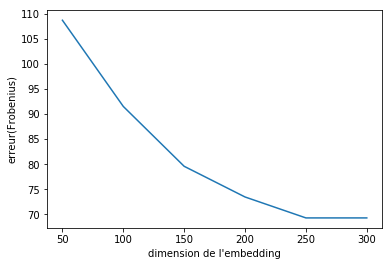

In [19]:
plt.plot(dims, errors)
plt.xlabel("dimension de l'embedding")
plt.ylabel("erreur(Frobenius)")
plt.show()

plt.plot(dims, scores)
plt.xlabel("dimension de l'embedding")
plt.ylabel("score classification")
plt.show()

Dans la suite on prendra donc une dimension de 250.

In [20]:
nmf = NMF(n_components=250, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tf_idf_total)

KeyboardInterrupt: 

In [21]:
from sklearn.externals import joblib

#joblib.dump(nmf, "nmf_250topics_20190408.save") 
nmf = joblib.load("nmf_250topics_20190408.save")

C:\Users\Pascal\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


FileNotFoundError: [Errno 2] No such file or directory: 'nmf_250topics_20190408.save'

### Calcul des top topics

In [22]:
X = pd.DataFrame(nmf.transform(tf_idf_total.todense())).set_index(df_seller.index.values).loc[df_train_main_fams.index]
X.rename(columns=dict(zip(range(250),['topic_'+str(i) for i in range(250)])),inplace=True)
Y = df_train_main_fams['Product_family_innoscape']
df_topics = df_train_main_fams.merge(X, how='inner', left_index=True, right_index=True)
df_topics['Product_family_innoscape'] = Y

In [24]:
col_names = ['topic_'+str(i) for i in range(250)]
weights = df_topics[col_names]
total_weights = np.sum(weights, axis=1)
df_topics['total_weights'] = total_weights
nulls = df_topics[df_topics['total_weights']==0].index
df_topics.drop(nulls, axis=0, inplace=True)
X.drop(nulls, axis=0, inplace=True)
Y.drop(nulls, inplace=True)

In [25]:
def get_top_topics(row, num_topics, num_top_topics):
    cols_to_fetch = ['topic_'+str(i) for i in range(num_topics)]
    top_topics_idx = np.argsort(-np.array(row[cols_to_fetch]))[:num_top_topics]
    top_topics_cols = ['topic_'+str(i) for i in top_topics_idx]
    top_topics_weights = row[top_topics_cols].values
    return [top_topics_idx,top_topics_weights]

def unpack_top_topics(df, top_topics_col,total_weights_col ,num_top_topics):
    col_names1 = ['top_topic_'+str(i) for i in range(1,num_top_topics+1)]
    col_names2 = ['top_topic_'+str(i)+'_relative_weight' for i in range(1,num_top_topics+1)]
    df2 = df.copy()
    for i in range(len(col_names1)):
        df2[col_names1[i]] = df[top_topics_col].apply(lambda x: x[0][i])
        df2[col_names2[i]] = df[top_topics_col].apply(lambda x: x[1][i])
        df2[col_names2[i]] = df2[col_names2[i]]/df2[total_weights_col]
    return df2

In [26]:
num_topics = 250
num_top_topics = 4
df_topics['top_top'] = df_topics.apply(get_top_topics, args=([num_topics,num_top_topics]), axis=1)
df_topics = unpack_top_topics(df_topics,'top_top','total_weights', num_top_topics)
df_topics.drop('top_top', axis=1, inplace=True)

In [27]:
topics_by_fam = df_topics.groupby('Product_family_innoscape').sum()
topics_by_fam = topics_by_fam[col_names]
total_weights = np.sum(topics_by_fam, axis=1)
topics_by_fam['total_weights'] = total_weights
topics_by_fam['top_top'] = topics_by_fam.apply(get_top_topics, args=([250,3]), axis=1)
topics_by_fam = unpack_top_topics(topics_by_fam,'top_top','total_weights', 3)

topics_by_fam[['top_topic_1','top_topic_1_relative_weight','top_topic_2','top_topic_2_relative_weight']].head(50)

top_topic_1  \
Product_family_innoscape                                          
accessoires chauffe-eau                                      12   
accessoires couverture                                      230   
accessoires et consommables outillage électropo...          137   
accessoires pour nettoyeur haute pression                   197   
accessoires pour outillage motorisé                         175   
ampoules et leds                                            174   
aménagements décoratifs                                      72   
anti-mousse                                                 248   
arrosage                                                     77   
aspirateurs, souffleurs, broyeurs                           103   
aérateur et vmc                                              88   
bardage                                                       4   
barre de seuil et nez de marche                              61   
batterie et chargeur                                         17   
brise-vue, canisse, brande, grillage et brise vent           58   
chauffage                                                   136   
chauffe-eau gaz                                             193   
chauffe-eau électrique                                       12   
conduit et accessoires d'aération                            20   
contenants                                                  211   
couverture                                                   14   
disjoncteur, coupe-circuit et interrupteur diff...           91   
divers                                                      134   
divers oep                                                  226   
débroussailleuse et coupe-bordures                           52   
défonceuse et lamelleuse et rabot                           154   
gouttière, descente et accessoires                            9   
grillage avertisseur et gaine de protection                   5   
mastic, colle, étanchéité                                    13   
meuleuse et rainureuse                                       24   
motobineuses et motoculteurs                                171   
mousse expansive                                            181   
outil motorisé modulable                                    175   
outillage à main                                            205   
outils multifonctions                                        37   
peinture                                                      6   
perceuse, perforateur et visseuse filaire                   153   
perceuse, perforateur et visseuse sans fil                   10   
pince et tenaille                                           190   
pistolet à colle et agrafeuse                               217   
plinthe bois, plinthe mdf, plinthe pvc                      241   
ponceuse électrique                                          33   
poudre béton, chaux, ciment, enduit, mortier, r...           59   
protection jardin, paillage, tuteurs et accesso...          227   
scies électriques                                            71   
taille-haies                                                 48   
tondeuses electriques, thermiques et autoportée               7   
tournevis (cruciforme, aimanté, de précision…)              165   
tronçonneuse, scie et fendeur de bois                        41   
vidage, bonde et siphon                                     220   

                                                    top_topic_1_relative_weight  \
Product_family_innoscape                                                          
accessoires chauffe-eau                                                0.474915   
accessoires couverture                                                 0.127009   
accessoires et consommables outillage électropo...                     0.090216   
accessoires pour nettoyeur haute pression                              0.147798   
accessoires pour outillage motorisé                                  

On va tout d'abord s'assurer qu'aucune paire de topics ne caractérise deux familles différentes:

In [28]:
topics_by_fam.shape[0]

50

In [29]:
top_topics_by_fam = topics_by_fam[['top_topic_1','top_topic_2']]
top_topics_by_fam.drop_duplicates()
top_topics_by_fam.shape[0]

50

Entraînement d'un classifieur de référence:

In [30]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y,test_size=0.2, random_state = 548)
    
#entraînement d'un classifieur sur le train set et calcul du score
etc_ref = ExtraTreesClassifier(max_depth=100,random_state=42, n_estimators=2000,n_jobs=-1)
etc_ref.fit(Xtrain,Ytrain)
score_ref = etc_ref.score(Xtest,Ytest)
print(score_ref)

0.9709443099273608


In [31]:
from sklearn.metrics import accuracy_score, f1_score
f1_score(Ytest,etc_ref.predict(Xtest),average='macro')

C:\Users\Pascal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.9277770092295389

### Identification des produits diffus et des topics diffus

Dictionnaires des correspondances entre topics, mots, et indices dans le tf-idf:

In [32]:
#extraction des composantes des topics dans l'espace du tf-idf:
topics_raw = nmf.components_

#correspondance des composantes en langage naturel
voc = vectorizer.vocabulary_
voc_reverse = dict(zip(voc.values(),voc.keys()))

#extraction des n premières composantes de chaque topic:
n_top = 6
topic_description = {}

for i in range(topics_raw.shape[0]):
    top_components = np.argsort(-topics_raw[i,:])[:n_top]
    weights = topics_raw[i,top_components]
    words = [voc_reverse[c] for c in top_components]
    explanation = dict(zip(words,weights))
    topic_description[i] = explanation

Voyons à présent s'il existe des topics peu concentrés autour de leurs premiers mots. Pour cela, voyons comment se répartissent en moyenne les poids des mots des topics.

In [33]:
topic_components = pd.DataFrame(topics_raw)
topic_components['total'] = np.sum(topic_components, axis=1)

#voyons déjà s'il existe des topics qui ne contiennent aucun mot, et retirons-les:
empty_topics = topic_components[topic_components['total']==0].index
topic_components.drop(empty_topics, axis=0, inplace=True)

In [34]:
empty_topics

Int64Index([ 26,  28,  30,  31,  49,  64,  65,  66,  68,  69,  70,  73,  74,
             78,  79,  80,  81,  82,  87,  89,  92,  94,  96,  97,  98, 100,
            101, 107, 108, 109, 111, 112, 113, 114, 119, 120, 124, 127, 129,
            130, 135, 138, 139, 140, 143, 144, 145, 148, 149, 152, 157, 158,
            161, 162, 170, 172, 180, 187, 189, 202],
           dtype='int64')

In [35]:
#normalisation des poids des mots:
for i in range(num_top_words):
    topic_components[i] = topic_components[i]/topic_components['total']

In [36]:
num_top_words = 500
n_main_words = 3

#tri des poids de chaque topic:
#initialisation:
coeffs_sorted = -np.sort(-topic_components.loc[0, range(num_top_words)])

#tri
for i in range(1,num_topics):
    if i in empty_topics:
        pass
    else:
        coeffs_sorted = np.vstack((coeffs_sorted, -np.sort(-topic_components.loc[i, range(num_top_words)])))

#calcul des poids cumulés et agrégation:
cum_weights = np.cumsum(coeffs_sorted, axis=1)
total_cum_weights = np.sum(cum_weights, axis=0)/cum_weights.shape[0]


threshold = 0.6
indices  = [i for i in range(num_topics) if i not in empty_topics]
weights_top_words = pd.Series(cum_weights[:,n_main_words], index= indices)
#weights_top_words['total']=np.sum(weights_top_words, axis=1)
diffuse_topics = weights_top_words[weights_top_words<threshold].index
diffuse_topics

Int64Index([6, 20, 58, 177, 200], dtype='int64')

On considère comme diffus les topics dont les 3 premiers mots représentent moins de 60% des coefficients:

Voyons plus en détail ce que contiennent ces topics:

In [37]:
for t in diffuse_topics:
    print('topic_'+str(t)+':')
    print(topic_description[t])
    print('_'*30)
    print()

topic_6:
{'ite': 4.324166914019041, 'revetement': 3.62838859541795, 'facade': 3.0572394648749115, 'enduit': 2.5987028220843422, 'platre': 2.183167003523513, 'isolation': 2.164954988390234}
______________________________

topic_20:
{'conduire': 3.2906059849521068, 'aeration': 3.0742177203706467, 'deshumidificateur': 1.3083948483746015, 'vmc': 1.2746271390056796, 'accessoire': 1.2470543697207792, 'aerateur': 1.1480785044632533}
______________________________

topic_58:
{'canisse': 2.025382281709432, 'briser': 2.010627892404478, 'grillage': 1.42414480652669, 'vent': 1.3770244047169635, 'brande': 1.2927187967834923, 'vue': 1.2434418073065865}
______________________________

topic_177:
{'produire': 2.1798522527563997, 'restauration': 2.171125783042868, 'resine': 2.1570413171587877, 'entretien': 2.054461130960341, 'fixation': 1.3225844885157105, 'revetement': 0.9550312782574534}
______________________________

topic_200:
{'descente': 4.336723496933484, 'gouttiere': 3.1986711836017845, 'racco

Voyons dans quelle mesure des topics caractéristiques des familles font partie de ces topics diffus:

In [38]:
topic_list = list(set(topics_by_fam['top_topic_1'])|set(topics_by_fam['top_topic_2']))
intersection = [t for t in diffuse_topics if t in topic_list]
print(intersection)

[6, 20, 58, 200]


Clssification à partir des deux topics principaux :

In [39]:
X_toptop = df_topics[['top_topic_1',
       'top_topic_1_relative_weight', 'top_topic_2',
       'top_topic_2_relative_weight']]

In [40]:
X_toptop = df_topics[['top_topic_1',
       'top_topic_1_relative_weight', 'top_topic_2',
       'top_topic_2_relative_weight']].drop(nulls, axis=0)

X_toptop_train, X_toptop_test, Ytrain, Ytest = train_test_split(X_toptop,Y,test_size=0.2, random_state = 548)

#entraînement d'un classifieur sur le train set et calcul du score
etc_toptop_ref = ExtraTreesClassifier(max_depth=100,random_state=42, n_estimators=2000,n_jobs=-1)
etc_toptop_ref.fit(X_toptop_train,Ytrain)
score_toptop_ref = etc_toptop_ref.score(X_toptop_test,Ytest)
print(score_toptop_ref)

0.9031476997578692


### Retrait des produits et topics ambigus

#### 1- Produits ambigus car trop peu concentrés autour de leurs premiers topics

In [41]:
threshold = 0.6
df_topics['top1&2_weight'] = df_topics['top_topic_1_relative_weight']+df_topics['top_topic_2_relative_weight']
diffuse_products = df_topics[df_topics['top1&2_weight']<threshold].index
diffuse_products.shape

(1476,)

In [42]:
recap = df_topics.drop(diffuse_products, axis=0)
recap = recap.groupby('Product_family_innoscape').count()
min(recap.productfamily_seller)

5

#### 2- Produits ambigus car leurs premiers topics sont ambigus

In [43]:
empty_topics2 = ['topic_'+str(t) for t in empty_topics]
diffuse_topics2 = ['topic_'+str(t) for t in diffuse_topics]

In [44]:
prod_to_delete_idx1 = [i for i in df_topics.index if df_topics.loc[i,'top_topic_1'] in diffuse_topics]
prod_to_delete_idx2 = [i for i in df_topics.index if df_topics.loc[i,'top_topic_2'] in diffuse_topics]
prod_to_delete = list(set(prod_to_delete_idx1)|set(prod_to_delete_idx2))
len(prod_to_delete)

502

#### 3- Train set et test set

In [45]:
removed_products = list(diffuse_products)+prod_to_delete

In [46]:
X = df_topics[col_names].drop(removed_products, axis=0)
Y = df_topics['Product_family_innoscape'].drop(removed_products)


Retrait des familles avec trop peu d'effectifs:

In [47]:
recap = Y.value_counts()
rare_fams = recap[recap<10]
rare_prod = [i for i in Y.index if Y[i] in rare_fams]
len(rare_prod)

16

In [48]:
removed_products +=rare_prod
X.drop(rare_prod, axis=0, inplace=True)
Y.drop(rare_prod, axis=0, inplace=True)

Séparation train/test:

In [49]:
X_train, X_test, Ytrain, Ytest = train_test_split(X,Y,test_size=0.2, random_state = 548)

#### 4- Modèle

In [50]:
#entraînement d'un classifieur sur le train set et calcul du score
etc_clear = ExtraTreesClassifier(max_depth=100,random_state=42, n_estimators=2000,n_jobs=-1)
etc_clear.fit(X_train,Ytrain)
score_clear = etc_clear.score(X_test,Ytest)
print(score_clear)

0.9803695150115473


In [51]:
f1_score(Ytest,etc_clear.predict(X_test),average='macro')

C:\Users\Pascal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.9340581503101809

### Détermination du seuil de fiabilité des prédictions

In [52]:
soft_pred = etc_clear.predict_proba(X_test)
class_list = etc_clear.classes_
soft_pred.shape
pred = np.argmax(soft_pred, axis=1)
unsure_pred = [k for k in range(pred.shape[0]) if pred[k]<1]

In [53]:
def get_hard_pred(soft_pred, threshold,unsure_label, class_list):
    pred = np.argmax(soft_pred, axis=1)
    hard_pred = pd.Series([class_list[element] for element in pred])
    probas = np.max(soft_pred, axis=1)
    unsure_pred = [k for k in range(pred.shape[0]) if probas[k]<threshold]
    hard_pred[unsure_pred] = unsure_label
    return hard_pred

In [54]:
def count_zeros(conf_mat):
    #on exclut la diagonale en mettant systématiquement des 1:
    copy=conf_mat+np.identity(conf_mat.shape[0])
    copy=copy[:-1,:-1]
    #return (copy.shape[0]**2-np.count_nonzero(copy))/(copy.shape[0]*(copy.shape[0]-1))
    return np.count_nonzero(copy) - copy.shape[0]

In [55]:
def percent_reliable_pred(soft_pred,threshold):
    pred = np.argmax(soft_pred, axis=1)
    hard_pred = pd.Series([class_list[element] for element in pred])
    probas = np.max(soft_pred, axis=1)
    sure_pred = [k for k in range(pred.shape[0]) if probas[k]>=threshold]
    return len(sure_pred)/soft_pred.shape[0]

In [56]:
thresholds = np.arange(0,1.01,0.01)
scores = []
reliable_predictions =[]

for t in thresholds:
    pred = get_hard_pred(soft_pred, t,'à_valider', class_list)
    conf_mat = confusion_matrix(Ytest,pred)
    scores.append(count_zeros(conf_mat))
    reliable_predictions.append(percent_reliable_pred(soft_pred,t))

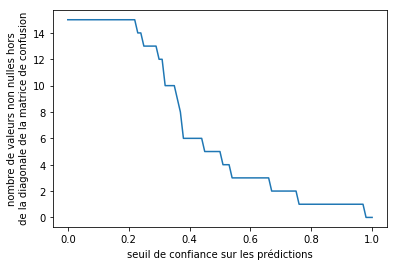

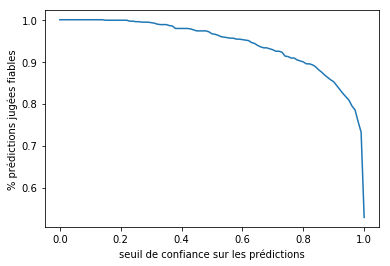

In [57]:
#affichage
plt.plot(thresholds, scores)
plt.xlabel("seuil de confiance sur les prédictions")
plt.ylabel('nombre de valeurs non nulles hors\n de la diagonale de la matrice de confusion')
plt.show()

plt.plot(thresholds, reliable_predictions)
plt.xlabel("seuil de confiance sur les prédictions")
plt.ylabel("% prédictions jugées fiables")
plt.show()

In [58]:
Y_pred = get_hard_pred(soft_pred, 0.5,'à_valider', class_list)
tbd = [i for i in range(Y_pred.shape[0]) if Y_pred[i]!='à_valider']

In [59]:
f1_score(Ytest.iloc[tbd],Y_pred[tbd],average='macro')

0.9803689181029424

In [60]:
accuracy_score(Ytest.iloc[tbd],Y_pred[tbd])

0.994026284348865